In [1]:
import json

import requests
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import geopandas as gpd
from shapely import geometry as sgeom
import rasterio as rio
import xarray as xr
from affine import Affine

How to change workflow:
* one function to create x array with slope and aspect elev, lc as a single xarray
* second function insret the dem to calculate the Hs to SWE 
* dask to speed up the Hs to SWE process 

In [2]:
########## USER ###########
# Select modeling domain ('WY', 'UT', 'OR', 'WA')
domain = 'WY'

In [3]:
#CSO data path
CSOpath = 'cso-data.geojson'
#assimilation files 
assimPath = '/nfs/attic/dfh/Aragon2/CSOassim/'+domain+'/'
# Figure path
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/'+domain+'/'

#path to CSO domain
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
    
#start date    
st = domains[domain]['st']
#end date
ed = domains[domain]['ed']

#Snotel bounding box
Bbox = domains[domain]['Bbox']

# CSO projection
stn_proj = domains[domain]['stn_proj']

# CSO projection
mod_proj = domains[domain]['mod_proj']

In [11]:
#edit time period 
#dates
st = '2018-09-01'
ed = '2019-09-30'

In [12]:
#Issue CSO API observations request and load the results into a GeoDataFrame
params = {
  "bbox": f"{Bbox['lonmin']},{Bbox['latmax']},{Bbox['lonmax']},{Bbox['latmin']}",
  "start_date": st,
  "end_date": ed,
  "format": "geojson",
  "limit": 5000,
}

csodata_resp = requests.get("https://api.communitysnowobs.org/observations", params=params)
csodatajson = csodata_resp.json()

In [13]:
CSO_gdf = gpd.GeoDataFrame.from_features(csodatajson, crs=stn_proj)

CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation
0,POINT (-110.79163 43.67342),4I+m2ikf,Nancy Bockino,100.0,SnowPilot,2020-12-22T19:00:00.000Z,2593.702637
1,POINT (-110.79139 43.67230),gPiHSibG,colin wann,95.0,SnowPilot,2020-12-22T18:30:00.000Z,2582.546875
2,POINT (-110.77795 43.71771),4wb25X9e,Tim Cohn,140.0,SnowPilot,2020-12-22T18:00:00.000Z,2442.216797
3,POINT (-110.77795 43.71771),Q3C4rDDH,Tim Cohn,140.0,SnowPilot,2020-12-22T18:00:00.000Z,2442.216797
4,POINT (-110.82946 43.63157),uPqn9apT,Christian Santelices,121.0,SnowPilot,2020-12-21T19:00:00.000Z,2491.021240
...,...,...,...,...,...,...,...
644,POINT (-110.94512 43.50662),ZieRtWwG,Mike Hardaker,220.0,SnowPilot,2017-01-09T03:46:30.000Z,2681.205078
645,POINT (-110.15553 44.46178),ZsTR7G2t,John McCurdy,165.0,SnowPilot,2016-12-23T17:46:29.000Z,2770.274658
646,POINT (-110.87574 43.57965),Fqnv6kiF,Bill Anderson,142.0,SnowPilot,2016-12-21T13:28:18.000Z,2823.013916
647,POINT (-110.87301 43.59553),t0HyUg9o,Mike Rheam,32.0,SnowPilot,2016-12-02T22:20:07.000Z,2997.033203


In [14]:
# projection
mod_proj = domains[domain]['mod_proj']
new=CSO_gdf.to_crs(mod_proj)
new

,geometry,id,author,depth,source,timestamp,elevation
0,POINT (516797.566 4835622.120),4I+m2ikf,Nancy Bockino,100.0,SnowPilot,2020-12-22T19:00:00.000Z,2593.702637
1,POINT (516816.903 4835497.779),gPiHSibG,colin wann,95.0,SnowPilot,2020-12-22T18:30:00.000Z,2582.546875
2,POINT (517887.095 4840544.244),4wb25X9e,Tim Cohn,140.0,SnowPilot,2020-12-22T18:00:00.000Z,2442.216797
3,POINT (517887.095 4840544.244),Q3C4rDDH,Tim Cohn,140.0,SnowPilot,2020-12-22T18:00:00.000Z,2442.216797
4,POINT (513757.461 4830967.251),uPqn9apT,Christian Santelices,121.0,SnowPilot,2020-12-21T19:00:00.000Z,2491.021240
...,...,...,...,...,...,...,...
644,POINT (504436.575 4817078.160),ZieRtWwG,Mike Hardaker,220.0,SnowPilot,2017-01-09T03:46:30.000Z,2681.205078
645,POINT (567177.357 4923510.576),ZsTR7G2t,John McCurdy,165.0,SnowPilot,2016-12-23T17:46:29.000Z,2770.274658
646,POINT (510032.501 4825195.160),Fqnv6kiF,Bill Anderson,142.0,SnowPilot,2016-12-21T13:28:18.000Z,2823.013916
647,POINT (510249.817 4826958.788),t0HyUg9o,Mike Rheam,32.0,SnowPilot,2016-12-02T22:20:07.000Z,2997.033203


# DEM

In [15]:
# dem path
dem_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/DEM_'+domain+'.tif'
da = xr.open_rasterio(dem_path)
transform = Affine.from_gdal(*da.attrs['transform'])
nx, ny = da.sizes['x'], da.sizes['y']
x, y = np.meshgrid(np.arange(nx)+0.5, np.arange(ny)+0.5) * transform
da

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  


<xarray.DataArray (band: 1, y: 2476, x: 1382)>
[3421832 values with dtype=int16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.938e+06 4.938e+06 4.937e+06 ... 4.69e+06 4.69e+06
  * x        (x) float64 4.872e+05 4.874e+05 4.874e+05 ... 6.252e+05 6.254e+05
Attributes:
    transform:      (100.0, 0.0, 487200.0, 0.0, -100.0, 4937700.0)
    crs:            +init=epsg:32612
    res:            (100.0, 100.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('elevation',)
    AREA_OR_POINT:  Area

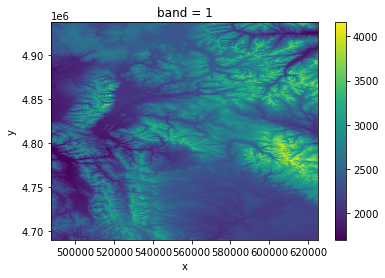

In [16]:
da.plot()

In [17]:
#this one
x_idx = []
y_idx = []
el=[]

for i in range(len(new)):
    minx = abs(new.geometry.x[i]-da.x.values)
    x=np.where(minx==min(abs(new.geometry.x[i]-da.x.values)))[0][0]
    x_idx.append(x)
    miny = abs(new.geometry.y[i]-da.y.values)
    y=np.where(miny==min(abs(new.geometry.y[i]-da.y.values)))[0][0]
    y_idx.append(y)
    el.append(da[:,y,x].values[0])
    
CSO_gdf['x_idx']=x_idx
CSO_gdf['y_idx']=y_idx
CSO_gdf['dem_el']=el
CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,dem_el
0,POINT (-110.79163 43.67342),4I+m2ikf,Nancy Bockino,100.0,SnowPilot,2020-12-22T19:00:00.000Z,2593.702637,295,1020,2487
1,POINT (-110.79139 43.67230),gPiHSibG,colin wann,95.0,SnowPilot,2020-12-22T18:30:00.000Z,2582.546875,296,1022,2451
2,POINT (-110.77795 43.71771),4wb25X9e,Tim Cohn,140.0,SnowPilot,2020-12-22T18:00:00.000Z,2442.216797,306,971,2764
3,POINT (-110.77795 43.71771),Q3C4rDDH,Tim Cohn,140.0,SnowPilot,2020-12-22T18:00:00.000Z,2442.216797,306,971,2764
4,POINT (-110.82946 43.63157),uPqn9apT,Christian Santelices,121.0,SnowPilot,2020-12-21T19:00:00.000Z,2491.021240,265,1067,2734
...,...,...,...,...,...,...,...,...,...,...
644,POINT (-110.94512 43.50662),ZieRtWwG,Mike Hardaker,220.0,SnowPilot,2017-01-09T03:46:30.000Z,2681.205078,172,1206,2884
645,POINT (-110.15553 44.46178),ZsTR7G2t,John McCurdy,165.0,SnowPilot,2016-12-23T17:46:29.000Z,2770.274658,799,141,2833
646,POINT (-110.87574 43.57965),Fqnv6kiF,Bill Anderson,142.0,SnowPilot,2016-12-21T13:28:18.000Z,2823.013916,228,1125,2922
647,POINT (-110.87301 43.59553),t0HyUg9o,Mike Rheam,32.0,SnowPilot,2016-12-02T22:20:07.000Z,2997.033203,230,1107,3107


In [18]:
#extract elevations from raster
el = []
for i in range(len(new)):
    el.append(da.sel(x=[int(new.geometry.x[i])], y=[int(new.geometry.y[i])],method='nearest').values[0][0][0])
new['dem_el']=el
new

,geometry,id,author,depth,source,timestamp,elevation,dem_el
0,POINT (516797.566 4835622.120),4I+m2ikf,Nancy Bockino,100.0,SnowPilot,2020-12-22T19:00:00.000Z,2593.702637,2487
1,POINT (516816.903 4835497.779),gPiHSibG,colin wann,95.0,SnowPilot,2020-12-22T18:30:00.000Z,2582.546875,2451
2,POINT (517887.095 4840544.244),4wb25X9e,Tim Cohn,140.0,SnowPilot,2020-12-22T18:00:00.000Z,2442.216797,2764
3,POINT (517887.095 4840544.244),Q3C4rDDH,Tim Cohn,140.0,SnowPilot,2020-12-22T18:00:00.000Z,2442.216797,2764
4,POINT (513757.461 4830967.251),uPqn9apT,Christian Santelices,121.0,SnowPilot,2020-12-21T19:00:00.000Z,2491.021240,2734
...,...,...,...,...,...,...,...,...
644,POINT (504436.575 4817078.160),ZieRtWwG,Mike Hardaker,220.0,SnowPilot,2017-01-09T03:46:30.000Z,2681.205078,2884
645,POINT (567177.357 4923510.576),ZsTR7G2t,John McCurdy,165.0,SnowPilot,2016-12-23T17:46:29.000Z,2770.274658,2833
646,POINT (510032.501 4825195.160),Fqnv6kiF,Bill Anderson,142.0,SnowPilot,2016-12-21T13:28:18.000Z,2823.013916,2922
647,POINT (510249.817 4826958.788),t0HyUg9o,Mike Rheam,32.0,SnowPilot,2016-12-02T22:20:07.000Z,2997.033203,3107


487200.0 4690100.0 625400.0 4937700.0


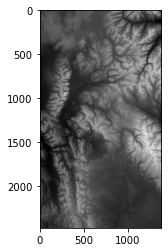

In [19]:
# dem path
dem_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/DEM_'+domain+'.tif'
# DEM data
src = rio.open(dem_path)
bound = src.bounds
minx = bound[0]
miny = bound[1]
maxx = bound[2]
maxy = bound[3]

#with rio.open(dtm) as src:
elevation = src.read(1)

print(minx,miny,maxx,maxy)
#plot
x = plt.imshow(src.read(1), cmap='gray')
plt.show()

In [20]:
#add x y values to CSO gdf
CSO_gdf['x']=new.geometry.x
CSO_gdf['y']=new.geometry.y
CSO_gdf.head()

,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,dem_el,x,y
0,POINT (-110.79163 43.67342),4I+m2ikf,Nancy Bockino,100.0,SnowPilot,2020-12-22T19:00:00.000Z,2593.702637,295,1020,2487,516797.565993,4.835622e+06
1,POINT (-110.79139 43.67230),gPiHSibG,colin wann,95.0,SnowPilot,2020-12-22T18:30:00.000Z,2582.546875,296,1022,2451,516816.903307,4.835498e+06
2,POINT (-110.77795 43.71771),4wb25X9e,Tim Cohn,140.0,SnowPilot,2020-12-22T18:00:00.000Z,2442.216797,306,971,2764,517887.095156,4.840544e+06
3,POINT (-110.77795 43.71771),Q3C4rDDH,Tim Cohn,140.0,SnowPilot,2020-12-22T18:00:00.000Z,2442.216797,306,971,2764,517887.095156,4.840544e+06
4,POINT (-110.82946 43.63157),uPqn9apT,Christian Santelices,121.0,SnowPilot,2020-12-21T19:00:00.000Z,2491.021240,265,1067,2734,513757.460807,4.830967e+06


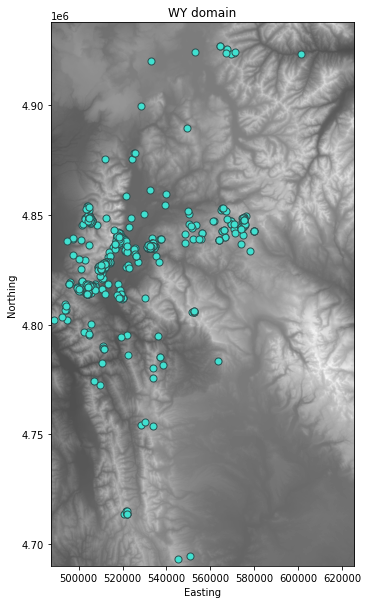

In [21]:
# plot georeferenced SnowModel output with SNOTEL stations 
fig, ax = plt.subplots(1,figsize=(8,10))

#hillshade and elevation
#ax.imshow(np.flipud(hillshade), origin = [minx,miny], extent = [minx,maxx,miny,maxy],cmap ='gray')
ax.imshow(np.flipud(elevation), origin = [minx,miny], extent = [minx,maxx,miny,maxy],cmap ='gray', alpha = 0.7)

ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

# title
plt.title(domain+' domain')

#stations
new.plot(ax=ax,markersize=50, color='turquoise', edgecolor = 'darkslategrey')

#leg = ax.get_legend()
#leg.set_bbox_to_anchor((1,1))


#plt.savefig(f"/nfs/attic/dfh/Aragon2/Notebooks/calibration_python/figs/test.png")#Python_Animation_02_frame_{i:04}.png")
plt.show()

In [22]:
#build list of coordinates from point geodataframe
xy = list(map(list, zip(new.geometry.x,new.geometry.y)))

In [23]:
#sample dem
with rio.open(dem_path) as src:
    CSO_gdf['dem_elev'] = [sample[0] for sample in src.sample(xy)]
CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,dem_el,x,y,dem_elev
0,POINT (-110.79163 43.67342),4I+m2ikf,Nancy Bockino,100.0,SnowPilot,2020-12-22T19:00:00.000Z,2593.702637,295,1020,2487,516797.565993,4.835622e+06,2487
1,POINT (-110.79139 43.67230),gPiHSibG,colin wann,95.0,SnowPilot,2020-12-22T18:30:00.000Z,2582.546875,296,1022,2451,516816.903307,4.835498e+06,2451
2,POINT (-110.77795 43.71771),4wb25X9e,Tim Cohn,140.0,SnowPilot,2020-12-22T18:00:00.000Z,2442.216797,306,971,2764,517887.095156,4.840544e+06,2764
3,POINT (-110.77795 43.71771),Q3C4rDDH,Tim Cohn,140.0,SnowPilot,2020-12-22T18:00:00.000Z,2442.216797,306,971,2764,517887.095156,4.840544e+06,2764
4,POINT (-110.82946 43.63157),uPqn9apT,Christian Santelices,121.0,SnowPilot,2020-12-21T19:00:00.000Z,2491.021240,265,1067,2734,513757.460807,4.830967e+06,2734
...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,POINT (-110.94512 43.50662),ZieRtWwG,Mike Hardaker,220.0,SnowPilot,2017-01-09T03:46:30.000Z,2681.205078,172,1206,2884,504436.575237,4.817078e+06,2884
645,POINT (-110.15553 44.46178),ZsTR7G2t,John McCurdy,165.0,SnowPilot,2016-12-23T17:46:29.000Z,2770.274658,799,141,2833,567177.356957,4.923511e+06,2833
646,POINT (-110.87574 43.57965),Fqnv6kiF,Bill Anderson,142.0,SnowPilot,2016-12-21T13:28:18.000Z,2823.013916,228,1125,2922,510032.500583,4.825195e+06,2922
647,POINT (-110.87301 43.59553),t0HyUg9o,Mike Rheam,32.0,SnowPilot,2016-12-02T22:20:07.000Z,2997.033203,230,1107,3107,510249.817152,4.826959e+06,3107


In [24]:
CSO_gdf['elev_bias'] =CSO_gdf.dem_elev-CSO_gdf.elevation

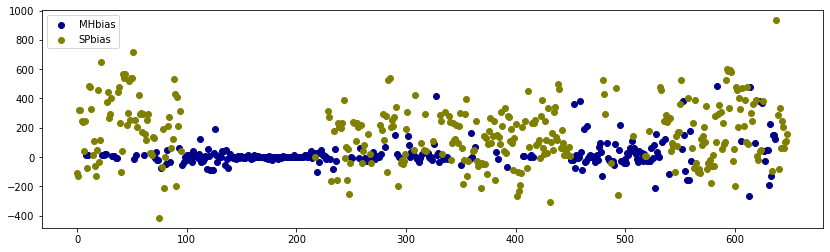

In [18]:
elev_bias = CSO_gdf.dem_elev-CSO_gdf.elevation

fig, ax = plt.subplots(1,figsize=(14,4))
#ax.scatter(CSO_gdf.index.values,elev_bias,label='bias')
ax.scatter(CSO_gdf.index.values[CSO_gdf.source == 'MountainHub'],elev_bias[CSO_gdf.source == 'MountainHub'],label='MHbias',color='darkblue')
ax.scatter(CSO_gdf.index.values[CSO_gdf.source == 'SnowPilot'],elev_bias[CSO_gdf.source == 'SnowPilot'],label='SPbias',color='olive')
ax.legend()

In [19]:
new2=new[CSO_gdf.elev_bias.abs()<10]
CSO_gdf2=CSO_gdf[CSO_gdf.elev_bias.abs()<10]
CSO_gdf2

,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,dem_el,x,y,dem_elev,elev_bias
32,POINT (-110.23602 43.77462),vTEdbxAz,JD,40.000000,MountainHub,2020-12-05T20:07:05.511Z,2547.139893,742,905,2554,561482.834574,4.847124e+06,2554,6.860107
33,POINT (-110.19192 43.73367),SLPnC+0g,JD,50.000000,MountainHub,2020-12-05T19:40:46.229Z,2720.827148,778,950,2727,565076.572054,4.842610e+06,2727,6.172852
34,POINT (-110.19192 43.73367),lSheYz+K,JD,41.000000,MountainHub,2020-12-05T19:25:42.164Z,2720.827148,778,950,2727,565076.572054,4.842610e+06,2727,6.172852
35,POINT (-110.17834 43.73817),4pqsG0jm,JD,39.000000,MountainHub,2020-12-05T19:16:52.850Z,2809.788818,789,945,2800,566165.185831,4.843121e+06,2800,-9.788818
71,POINT (-110.59531 43.66950),opQJZM+k,Danny Martin,70.999997,MountainHub,2020-03-05T17:44:05.016Z,2158.296143,454,1024,2150,532625.418675,4.835246e+06,2150,-8.296143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,POINT (-110.54287 43.21933),55YoBndF,Brad White,155.000000,SnowPilot,2018-02-24T22:56:13.000Z,2475.345703,499,1524,2481,537126.998540,4.785273e+06,2481,5.654297
525,POINT (-110.59339 43.66928),TzCWQ9FG,Greg Peck,65.000000,MountainHub,2018-02-21T20:31:32.047Z,2163.029785,455,1024,2158,532780.363201,4.835222e+06,2158,-5.029785
530,POINT (-110.95347 43.50014),0O7JDkYH,Allen OBannon,105.000000,MountainHub,2018-02-11T16:26:06.143Z,2650.888672,165,1213,2658,503761.477280,4.816358e+06,2658,7.111328
531,POINT (-110.85299 43.47758),TvLwiQWH,Allen OBannon,170.000000,MountainHub,2018-02-10T20:02:46.458Z,1869.280029,246,1238,1869,511888.919348,4.813862e+06,1869,-0.280029


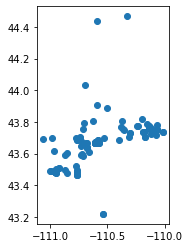

In [20]:
CSO_gdf2.plot()

In [144]:
path = figpath+'WYelev_bias.pdf'
fig.savefig(path, format='pdf', dpi=300)

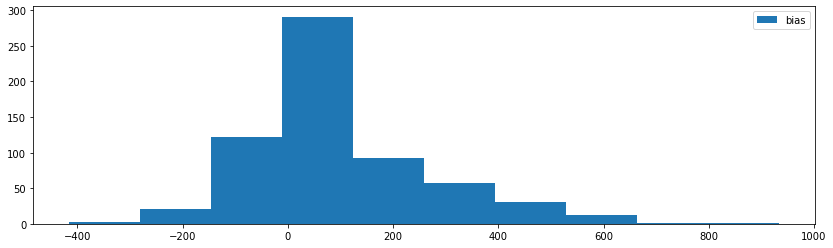

In [145]:
fig, ax = plt.subplots(1,figsize=(14,4))
ax.hist(elev_bias,label='bias')
ax.legend()

elevation categories 

# Slope

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


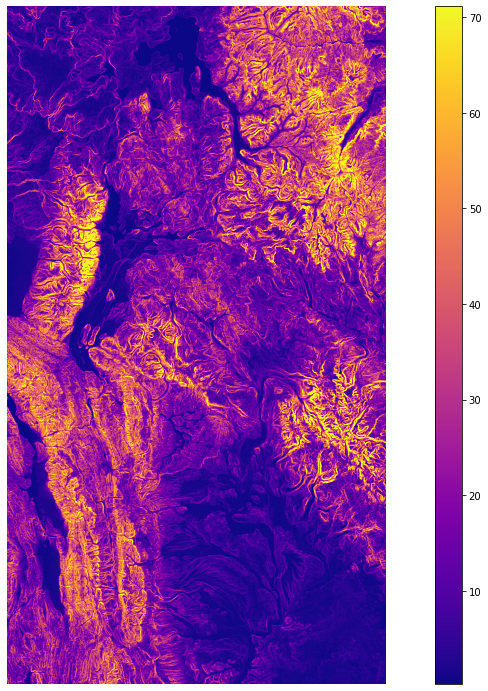

{'vmin': 0.25, 'vmax': 71.1556396484375}

In [21]:
import richdem as rd
from osgeo import gdal
ds = gdal.Open(dem_path)
data = np.array(ds.GetRasterBand(1).ReadAsArray())
rda = rd.rdarray(data, no_data=-9999)
slope = rd.TerrainAttribute(rda, attrib='slope_riserun')
rd.rdShow(slope, axes=False, cmap='plasma', figsize=(8,10))

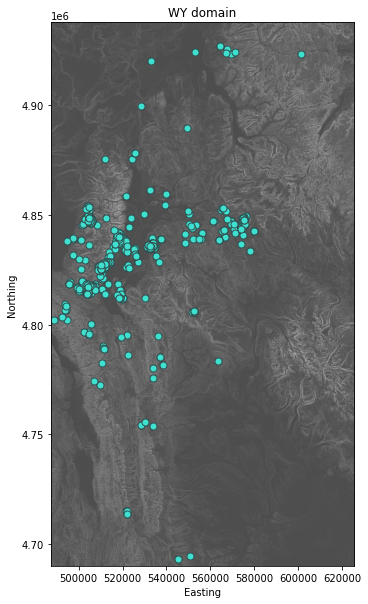

In [22]:
# plot georeferenced SnowModel output with SNOTEL stations 
fig, ax = plt.subplots(1,figsize=(8,10))

#hillshade and elevation
#ax.imshow(np.flipud(hillshade), origin = [minx,miny], extent = [minx,maxx,miny,maxy],cmap ='gray')
ax.imshow(np.flipud(slope), origin = [minx,miny], extent = [minx,maxx,miny,maxy],cmap ='gray', alpha = 0.7)

ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

# title
plt.title(domain+' domain')

#stations
new.plot(ax=ax,markersize=50, color='turquoise', edgecolor = 'darkslategrey')

#leg = ax.get_legend()
#leg.set_bbox_to_anchor((1,1))


#plt.savefig(f"/nfs/attic/dfh/Aragon2/Notebooks/calibration_python/figs/test.png")#Python_Animation_02_frame_{i:04}.png")
plt.show()

In [23]:
with rio.open(dem_path) as src:
    rows, cols = rio.transform.rowcol(src.transform, new.geometry.centroid.x, new.geometry.centroid.y)
CSO_gdf['slope'] = slope[rows,cols]
CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,dem_el,x,y,dem_elev,elev_bias,slope
0,POINT (-110.82068 43.63186),kRNq6629,Nancy Bockino,95.0,SnowPilot,2020-12-19T19:00:00.000Z,2444.154785,272,1066,2486,514465.418488,4.831001e+06,2486,41.845215,56.147129
1,POINT (-110.94029 43.30884),gbFP8YdF,John Wauters,120.0,SnowPilot,2020-12-18T21:00:00.000Z,2578.827637,176,1425,2822,504842.255356,4.795113e+06,2822,243.172363,51.861897
2,POINT (-110.17419 43.70770),VvMsSZLm,Jason Dunlop,65.0,MountainHub,2020-12-18T20:23:09.847Z,2728.233887,793,979,2741,566533.132223,4.839740e+06,2741,12.766113,12.890161
3,POINT (-110.95010 43.32087),lt3f7f47,John Wauters,130.0,SnowPilot,2020-12-18T19:00:00.000Z,2623.367432,168,1412,2546,504046.200406,4.796450e+06,2546,-77.367432,46.490925
4,POINT (-110.17419 43.70770),RX316Xbx,Jason Dunlop,75.0,MountainHub,2020-12-18T18:52:01.190Z,2728.233887,793,979,2741,566533.132223,4.839740e+06,2741,12.766113,12.890161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,POINT (-110.94512 43.50662),ZieRtWwG,Mike Hardaker,220.0,SnowPilot,2017-01-09T03:46:30.000Z,2681.205078,172,1206,2884,504436.575237,4.817078e+06,2884,202.794922,51.266460
639,POINT (-110.15553 44.46178),ZsTR7G2t,John McCurdy,165.0,SnowPilot,2016-12-23T17:46:29.000Z,2770.274658,799,141,2833,567177.356957,4.923511e+06,2833,62.725342,24.192587
640,POINT (-110.87574 43.57965),Fqnv6kiF,Bill Anderson,142.0,SnowPilot,2016-12-21T13:28:18.000Z,2823.013916,228,1125,2922,510032.500583,4.825195e+06,2922,98.986084,9.519716
641,POINT (-110.87301 43.59553),t0HyUg9o,Mike Rheam,32.0,SnowPilot,2016-12-02T22:20:07.000Z,2997.033203,230,1107,3107,510249.817152,4.826959e+06,3107,109.966797,36.582100


# Aspect

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


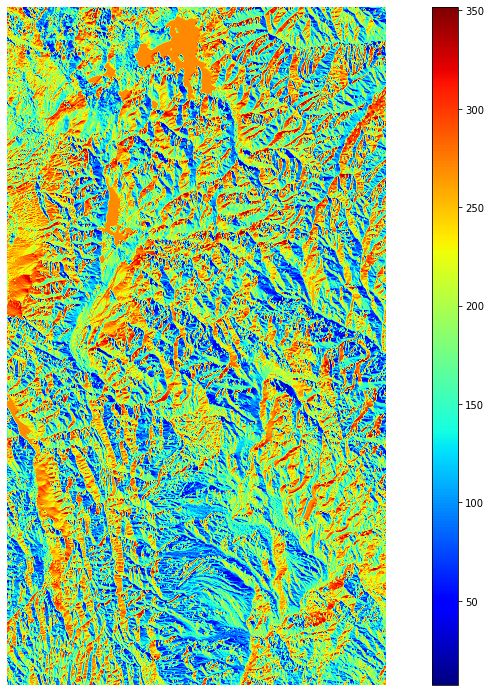

{'vmin': 7.284023761749268, 'vmax': 351.52886962890625}

In [24]:
rda = rd.rdarray(data, no_data=-9999)
aspect = rd.TerrainAttribute(rda, attrib='aspect')
rd.rdShow(aspect, axes=False, cmap='jet', figsize=(8,10))

In [25]:
#0=N, 1=NE, 2=E, 3=SE, 4=S, 5=SW, 6=W, 7=NW, 8=flat
DIR=aspect
DIR[(DIR>=0) & (DIR<=22.5)]=0
DIR[(DIR>22.5) & (DIR<=67.5)]=1
DIR[(DIR>67.5) & (DIR<=112.5)]=2
DIR[(DIR>112.5) & (DIR<=157.5)]=3
DIR[(DIR>157.5) & (DIR<=202.5)]=4
DIR[(DIR>202.5) & (DIR<=247.5)]=5
DIR[(DIR>247.5) & (DIR<=292.5)]=6
DIR[(DIR>292.5) & (DIR<=337.5)]=7
DIR[(DIR>337.5) & (DIR<=360)]=0
DIR[slope < 0.5]=8
DIR.astype(int)


rdarray([[6, 6, 6, ..., 5, 6, 5],
         [6, 6, 6, ..., 4, 5, 5],
         [7, 6, 6, ..., 5, 5, 5],
         ...,
         [4, 4, 4, ..., 5, 6, 6],
         [4, 4, 5, ..., 5, 6, 6],
         [4, 5, 6, ..., 6, 6, 6]])

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5]


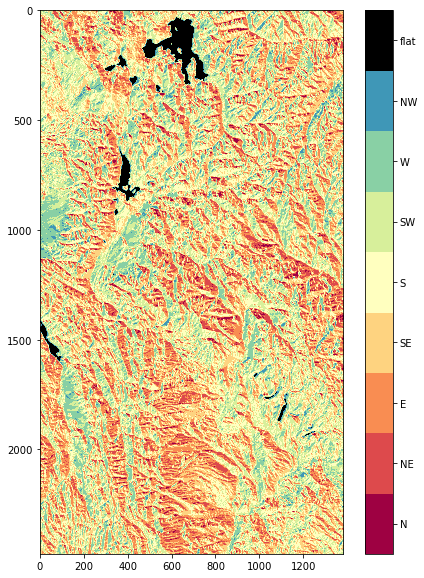

In [26]:
import matplotlib
from matplotlib.colors import ListedColormap

#select colormap
cmap = plt.get_cmap('Spectral', 9)

# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
col_dict={0:cmap(0), 1:cmap(1), 2:cmap(2), 3:cmap(3), 
          4:cmap(4), 5:cmap(5), 6:cmap(6), 7:cmap(7),8:'black'}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = np.array(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW','flat'])
len_lab = len(labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
print(norm_bins)
## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

# Plot our figure
fig,ax = plt.subplots(1,figsize=(8,10))
im = ax.imshow(DIR, cmap=cm, norm=norm)

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cb = fig.colorbar(im, format=fmt, ticks=tickz)
#fig.savefig("aspect.png")
plt.show()

In [27]:
CSO_gdf['aspect'] = DIR[rows,cols]
CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,dem_el,x,y,dem_elev,elev_bias,slope,aspect
0,POINT (-110.82068 43.63186),kRNq6629,Nancy Bockino,95.0,SnowPilot,2020-12-19T19:00:00.000Z,2444.154785,272,1066,2486,514465.418488,4.831001e+06,2486,41.845215,56.147129,2.0
1,POINT (-110.94029 43.30884),gbFP8YdF,John Wauters,120.0,SnowPilot,2020-12-18T21:00:00.000Z,2578.827637,176,1425,2822,504842.255356,4.795113e+06,2822,243.172363,51.861897,0.0
2,POINT (-110.17419 43.70770),VvMsSZLm,Jason Dunlop,65.0,MountainHub,2020-12-18T20:23:09.847Z,2728.233887,793,979,2741,566533.132223,4.839740e+06,2741,12.766113,12.890161,2.0
3,POINT (-110.95010 43.32087),lt3f7f47,John Wauters,130.0,SnowPilot,2020-12-18T19:00:00.000Z,2623.367432,168,1412,2546,504046.200406,4.796450e+06,2546,-77.367432,46.490925,2.0
4,POINT (-110.17419 43.70770),RX316Xbx,Jason Dunlop,75.0,MountainHub,2020-12-18T18:52:01.190Z,2728.233887,793,979,2741,566533.132223,4.839740e+06,2741,12.766113,12.890161,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,POINT (-110.94512 43.50662),ZieRtWwG,Mike Hardaker,220.0,SnowPilot,2017-01-09T03:46:30.000Z,2681.205078,172,1206,2884,504436.575237,4.817078e+06,2884,202.794922,51.266460,3.0
639,POINT (-110.15553 44.46178),ZsTR7G2t,John McCurdy,165.0,SnowPilot,2016-12-23T17:46:29.000Z,2770.274658,799,141,2833,567177.356957,4.923511e+06,2833,62.725342,24.192587,0.0
640,POINT (-110.87574 43.57965),Fqnv6kiF,Bill Anderson,142.0,SnowPilot,2016-12-21T13:28:18.000Z,2823.013916,228,1125,2922,510032.500583,4.825195e+06,2922,98.986084,9.519716,2.0
641,POINT (-110.87301 43.59553),t0HyUg9o,Mike Rheam,32.0,SnowPilot,2016-12-02T22:20:07.000Z,2997.033203,230,1107,3107,510249.817152,4.826959e+06,3107,109.966797,36.582100,4.0


# Landcover

### Snowmodel LC Codes

|Code  |Landcover Class |Code  |Landcover Class |
| --- | --- | --- | --- |
|1     | coniferous forest |13    | subalpine meadow  |      
|2     | deciduous forest |14    | tundra (non-tussock) |      
|3     | mixed forest |15    | tundra (tussock) |           
|4     | scattered short-conifer |16    | prostrate shrub tundra | 
|5     | clearcut conifer |17    | arctic gram. wetland |       
|6     | mesic upland shrub |18    | bare |       
|7     | xeric upland shrub |19    | water/possibly frozen |       
|8     | playa shrubland |20    | permanent snow/glacier |         
|9     | shrub wetland/riparian |21    | residential/urban |   
|10    | erect shrub tundra |22    | tall crops |       
|11    | low shrub tundra |23    | short crops |        
|12    | grassland rangeland  |24    | ocean |    
      

[ 0.5  1.5  2.5  6.5  9.5 12.5 18.5 20.5 21.5 22.5 23.5 24.5]


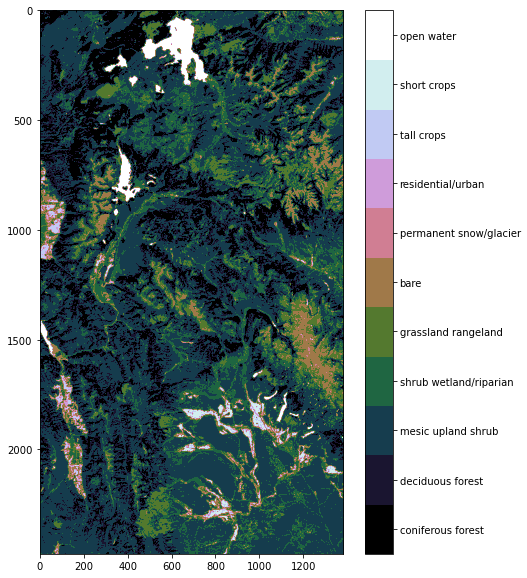

In [28]:
# nlcd path
lc_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/NLCD2016_'+domain+'.tif'


# DEM data
src = rio.open(lc_path)
bound = src.bounds
minx = bound[0]
miny = bound[1]
maxx = bound[2]
maxy = bound[3]

#with rio.open(dtm) as src:
lc = src.read(1)

# #reassign lc from NLCD to SM classes
DIR=DIR=np.empty([np.shape(lc)[0],np.shape(lc)[1]])
DIR[lc == 11 ]=24
DIR[lc == 12 ]=20
DIR[lc == 21 ]=21
DIR[lc == 22 ]=21
DIR[lc == 23 ]=21
DIR[lc == 24 ]=21
DIR[lc == 31 ]=18
DIR[lc == 41 ]=2
DIR[lc == 42 ]=1
DIR[lc == 43 ]=6
DIR[lc == 51 ]=6
DIR[lc == 52 ]=6
DIR[lc == 71 ]=12
DIR[lc == 72 ]=12
DIR[lc == 73 ]=12
DIR[lc == 74 ]=12
DIR[lc == 81 ]=23
DIR[lc == 82 ]=22
DIR[lc == 90 ]=9
DIR[lc == 95 ]=9
DIR.astype(int)

#plot
#select colormap
cmap = plt.get_cmap('cubehelix',11)

# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
#nlcd
# col_dict={11:'cyan', 12:cmap(1), 21:cmap(2), 22:cmap(3), 23:cmap(4), 
#           24:cmap(5), 31:cmap(6), 41:cmap(7), 42:cmap(8), 43:cmap(9), 
#           52:cmap(10), 71:cmap(11), 81:cmap(12), 82:cmap(13), 90:cmap(14),95:cmap(15)}
#sm
col_dict={1:cmap(0), 2:cmap(1), 6:cmap(2), 9:cmap(3), 12:cmap(4), 
          18:cmap(5), 20:cmap(6), 21:cmap(7), 22:cmap(8), 23:cmap(9), 24:cmap(10)}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category
#nlcd
# labels = np.array(['11', '12', '21', '22', '23', '24', '31', '41',
#                    '42', '43', '52', '71', '81', '82', '90', '95'])
# #sm nums
# labels = np.array(['1', '2', '6', '9', '12', '18', '20', '21',
#                    '22', '23','24'])
#sm names
labels = np.array(['coniferous forest', 'deciduous forest', 'mesic upland shrub', 'shrub wetland/riparian', 
                   'grassland rangeland', 'bare', 'permanent snow/glacier', 'residential/urban',
                   'tall crops', 'short crops','open water'])

len_lab = len(labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
print(norm_bins)
## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

# Plot our figure
fig,ax = plt.subplots(1,figsize=(8,10))
im = ax.imshow(DIR, cmap=cm, norm=norm)

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cb = fig.colorbar(im, format=fmt, ticks=tickz)
#fig.savefig("lc.png")
plt.show()

# fig, ax = plt.subplots(1,figsize=(8,10))
# im = ax.imshow(src.read(1), cmap='Set3')
# cb = fig.colorbar(im)

In [29]:
#sample lc
CSO_gdf['lc'] = DIR[rows,cols]
CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,dem_el,x,y,dem_elev,elev_bias,slope,aspect,lc
0,POINT (-110.82068 43.63186),kRNq6629,Nancy Bockino,95.0,SnowPilot,2020-12-19T19:00:00.000Z,2444.154785,272,1066,2486,514465.418488,4.831001e+06,2486,41.845215,56.147129,2.0,1.0
1,POINT (-110.94029 43.30884),gbFP8YdF,John Wauters,120.0,SnowPilot,2020-12-18T21:00:00.000Z,2578.827637,176,1425,2822,504842.255356,4.795113e+06,2822,243.172363,51.861897,0.0,1.0
2,POINT (-110.17419 43.70770),VvMsSZLm,Jason Dunlop,65.0,MountainHub,2020-12-18T20:23:09.847Z,2728.233887,793,979,2741,566533.132223,4.839740e+06,2741,12.766113,12.890161,2.0,1.0
3,POINT (-110.95010 43.32087),lt3f7f47,John Wauters,130.0,SnowPilot,2020-12-18T19:00:00.000Z,2623.367432,168,1412,2546,504046.200406,4.796450e+06,2546,-77.367432,46.490925,2.0,6.0
4,POINT (-110.17419 43.70770),RX316Xbx,Jason Dunlop,75.0,MountainHub,2020-12-18T18:52:01.190Z,2728.233887,793,979,2741,566533.132223,4.839740e+06,2741,12.766113,12.890161,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,POINT (-110.94512 43.50662),ZieRtWwG,Mike Hardaker,220.0,SnowPilot,2017-01-09T03:46:30.000Z,2681.205078,172,1206,2884,504436.575237,4.817078e+06,2884,202.794922,51.266460,3.0,12.0
639,POINT (-110.15553 44.46178),ZsTR7G2t,John McCurdy,165.0,SnowPilot,2016-12-23T17:46:29.000Z,2770.274658,799,141,2833,567177.356957,4.923511e+06,2833,62.725342,24.192587,0.0,12.0
640,POINT (-110.87574 43.57965),Fqnv6kiF,Bill Anderson,142.0,SnowPilot,2016-12-21T13:28:18.000Z,2823.013916,228,1125,2922,510032.500583,4.825195e+06,2922,98.986084,9.519716,2.0,6.0
641,POINT (-110.87301 43.59553),t0HyUg9o,Mike Rheam,32.0,SnowPilot,2016-12-02T22:20:07.000Z,2997.033203,230,1107,3107,510249.817152,4.826959e+06,3107,109.966797,36.582100,4.0,12.0


In [30]:
CSO_gdf['dt'] = pd.to_datetime(CSO_gdf['timestamp'], format='%Y-%m-%dT%H:%M:%S')
CSO_gdf['dt'] = pd.to_datetime(CSO_gdf['dt']).dt.date
#CSO_gdf.sort_values(by='dt') 

In [32]:
CSO_gdf['Y'] = pd.DatetimeIndex(CSO_gdf['dt']).year
CSO_gdf['M'] = pd.DatetimeIndex(CSO_gdf['dt']).month
CSO_gdf['D'] = pd.DatetimeIndex(CSO_gdf['dt']).day
CSO_gdf["LON"] = CSO_gdf.geometry.x
CSO_gdf["LAT"] = CSO_gdf.geometry.y
#convert snow depth to mm to input into density function
CSO_gdf['H'] = CSO_gdf.depth*10
CSO_gdf.head()

,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,dem_el,...,slope,aspect,lc,dt,Y,M,D,LON,LAT,H
0,POINT (-110.82068 43.63186),kRNq6629,Nancy Bockino,95.0,SnowPilot,2020-12-19T19:00:00.000Z,2444.154785,272,1066,2486,...,56.147129,2.0,1.0,2020-12-19,2020,12,19,-110.820680,43.631861,950.0
1,POINT (-110.94029 43.30884),gbFP8YdF,John Wauters,120.0,SnowPilot,2020-12-18T21:00:00.000Z,2578.827637,176,1425,2822,...,51.861897,0.0,1.0,2020-12-18,2020,12,18,-110.940292,43.308836,1200.0
2,POINT (-110.17419 43.70770),VvMsSZLm,Jason Dunlop,65.0,MountainHub,2020-12-18T20:23:09.847Z,2728.233887,793,979,2741,...,12.890161,2.0,1.0,2020-12-18,2020,12,18,-110.174187,43.707699,650.0
3,POINT (-110.95010 43.32087),lt3f7f47,John Wauters,130.0,SnowPilot,2020-12-18T19:00:00.000Z,2623.367432,168,1412,2546,...,46.490925,2.0,6.0,2020-12-18,2020,12,18,-110.950098,43.320874,1300.0
4,POINT (-110.17419 43.70770),RX316Xbx,Jason Dunlop,75.0,MountainHub,2020-12-18T18:52:01.190Z,2728.233887,793,979,2741,...,12.890161,2.0,1.0,2020-12-18,2020,12,18,-110.174187,43.707699,750.0


In [33]:
print('Total number of CSO in daimain = ',len(CSO_gdf))

Total number of CSO in daimain =  643


In [34]:
#write function to select data based on 
#date, elevation bounds, landcover class, slope, aspect 
#returns subset df 

In [20]:
mask = (CSO_gdf['timestamp'] >= '2018-09-01') & (CSO_gdf['timestamp'] <= '2019-09-30')
CSO_gdf = CSO_gdf.loc[mask]

In [21]:
CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,dem_el,x,y,dem_elev,elev_bias
141,POINT (-110.59782 43.67017),D3gyiOmE,Katie O’Connell,10.00,MountainHub,2019-04-25T02:25:30.037Z,2131.137695,452,1023,2128,532422.643976,4.835319e+06,2128,-3.137695
142,POINT (-110.59854 43.67067),SEJG7WBM,Katie O’Connell,72.00,MountainHub,2019-04-25T02:24:32.498Z,2127.995361,451,1023,2124,532364.144681,4.835374e+06,2124,-3.995361
143,POINT (-110.59358 43.67015),Vn9QgQA7,Leanne,27.94,MountainHub,2019-04-24T15:56:24.335Z,2146.224609,455,1023,2147,532764.130403,4.835319e+06,2147,0.775391
144,POINT (-110.59122 43.67052),xlFXLIST,Leanne,25.40,MountainHub,2019-04-24T15:53:28.932Z,2156.758057,457,1023,2154,532954.088693,4.835360e+06,2154,-2.758057
145,POINT (-110.59858 43.66764),4EMEMrPA,Colton Lewer,60.00,MountainHub,2019-04-24T15:53:19.864Z,2188.988770,451,1026,2178,532362.586657,4.835038e+06,2178,-10.988770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,POINT (-110.94137 43.78968),RlB3wF6G,Fred Most,56.00,SnowPilot,2018-11-12T16:39:00.000Z,2760.414795,175,891,2811,504716.859665,4.848515e+06,2811,50.585205
447,POINT (-110.95167 43.47857),6+xKcZFv,Chris McCollister,68.00,SnowPilot,2018-11-09T00:20:00.000Z,2794.276123,167,1237,2805,503908.588273,4.813962e+06,2805,10.723877
448,POINT (-110.85020 43.60553),7MKrMQAz,Josh Pope,95.00,SnowPilot,2018-11-08T17:30:00.000Z,2773.990234,248,1096,2786,512089.610379,4.828072e+06,2786,12.009766
449,POINT (-110.85548 43.60229),BBqIOtV3,Mike Rheam,65.00,SnowPilot,2018-11-08T17:00:00.000Z,2794.865967,244,1099,2861,511663.718663,4.827712e+06,2861,66.134033


# Hs to SWE

In [37]:
################################################################################
from Depth2SWE import swe_calc
SWE,DOY = swe_calc(CSO_gdf.Y.values,CSO_gdf.M.values,CSO_gdf.D.values,CSO_gdf.H.values,CSO_gdf.LAT.values,CSO_gdf.LON.values)
print(SWE,DOY)

[  33.62560084  245.73400465   94.85081256   86.54990826  203.86668587
   94.82340382  135.82567603   51.35133372  152.94286949   86.01522844
   77.23022596  155.49563369  228.24700771  135.7547509   138.02678238
  259.11082457   85.98030872  108.37697572  311.85338821   31.89634516
  246.8545467   269.20898243  224.51974361  217.78182027  186.31092224
  100.14304338  225.12520685  242.0255098   228.50451663  225.12520685
  264.39326725  110.49280941  277.9381157   243.25792405  261.48849117
  299.32573969  204.85755961  235.26535832  221.74628074  746.51841656
  232.39044766  221.74628074  268.4675024   252.29342383  258.93490786
  265.89125418  200.96064188  270.926531    215.48396607  228.50451663
  204.32478152  237.7341501   189.49677709  231.16877386  235.26427045
  264.15631588  213.27974494  230.09755968  253.29959387  231.88420586
  252.88445033  218.99189922  286.00776485  252.36363402  269.06912592
  184.60473012  231.51488604  261.88978681  312.5115655   152.16762786
  671.

In [38]:
#convert swe to m to input into SM
CSO_gdf['swe']=SWE/1000
CSO_gdf['doy']=DOY
CSO_gdf

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,dem_el,...,lc,dt,Y,M,D,LON,LAT,H,swe,doy
135,POINT (-110.59782 43.67017),D3gyiOmE,Katie O’Connell,10.00,MountainHub,2019-04-25T02:25:30.037Z,2131.137695,452,1023,2128,...,6.0,2019-04-25,2019,4,25,-110.597819,43.670172,100.0,0.033626,207
136,POINT (-110.59854 43.67067),SEJG7WBM,Katie O’Connell,72.00,MountainHub,2019-04-25T02:24:32.498Z,2127.995361,451,1023,2124,...,6.0,2019-04-25,2019,4,25,-110.598541,43.670671,720.0,0.245734,207
137,POINT (-110.59358 43.67015),Vn9QgQA7,Leanne,27.94,MountainHub,2019-04-24T15:56:24.335Z,2146.224609,455,1023,2147,...,2.0,2019-04-24,2019,4,24,-110.593583,43.670154,279.4,0.094851,206
138,POINT (-110.59122 43.67052),xlFXLIST,Leanne,25.40,MountainHub,2019-04-24T15:53:28.932Z,2156.758057,457,1023,2154,...,1.0,2019-04-24,2019,4,24,-110.591224,43.670517,254.0,0.086550,206
139,POINT (-110.59858 43.66764),4EMEMrPA,Colton Lewer,60.00,MountainHub,2019-04-24T15:53:19.864Z,2188.988770,451,1026,2178,...,1.0,2019-04-24,2019,4,24,-110.598580,43.667641,600.0,0.203867,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,POINT (-110.94137 43.78968),RlB3wF6G,Fred Most,56.00,SnowPilot,2018-11-12T16:39:00.000Z,2760.414795,175,891,2811,...,1.0,2018-11-12,2018,11,12,-110.941374,43.789676,560.0,0.117115,43
441,POINT (-110.95167 43.47857),6+xKcZFv,Chris McCollister,68.00,SnowPilot,2018-11-09T00:20:00.000Z,2794.276123,167,1237,2805,...,1.0,2018-11-09,2018,11,9,-110.951670,43.478566,680.0,0.137963,40
442,POINT (-110.85020 43.60553),7MKrMQAz,Josh Pope,95.00,SnowPilot,2018-11-08T17:30:00.000Z,2773.990234,248,1096,2786,...,6.0,2018-11-08,2018,11,8,-110.850197,43.605528,950.0,0.193702,39
443,POINT (-110.85548 43.60229),BBqIOtV3,Mike Rheam,65.00,SnowPilot,2018-11-08T17:00:00.000Z,2794.865967,244,1099,2861,...,12.0,2018-11-08,2018,11,8,-110.855482,43.602289,650.0,0.134792,39


In [39]:
assimPath = '/nfs/attic/dfh/Aragon2/CSOassim/'+domain+'/'
filename = assimPath+'CSO_assim_2018-2019_all.csv'
#save data for later reference 
CSO_gdf.to_csv(filename)

# Print data for SM
c A single data file describes the observation information that will be used in the data assimilation.  This file contains the following information in the following format.  The id can be any number, x and y are easting and northing in m, and swe is in m).

```
c   total_number_of_observation_dates_for_this_year
c   iyr imo idy (for this observation date)
c   number_of_stations_for_this_observation_date
c   id x y swe
c   id x y swe
c   id x y swe
c   iyr imo idy (for this observation date)
c   number_of_stations_for_this_observation_date
c   id x y swe
c   id x y swe
```

For example:
```
c   2
c   2014 3 15
c   3
c   101 3456.7 23677.4 0.42
c   102 3556.3 25079.3 0.52
c   103 3106.2 29089.3 0.59
c   2014 4 1
c   2
c   101 3456.7 23677.4 0.48
c   103 3106.2 29089.3 0.62
```

Then this repeats for each year of the assimilation (the inputfile looks like the above for a single-year run, and for multi-year runs the data for each following year is just stacked on top of the previous year).  The example below is for a two-year assimilation run.

In [10]:
# load previously made file 
CSO_obs = assimPath+'CSO_assim_2018-2019_all.csv'
CSO_gdf2 = pd.read_csv(CSO_obs)
CSO_gdf2

,Unnamed: 0,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,...,lc,dt,Y,M,D,LON,LAT,H,swe,doy
0,135,POINT (-110.597818510855 43.6701724330154),D3gyiOmE,Katie O’Connell,10.00,MountainHub,2019-04-25T02:25:30.037Z,2131.137695,452,1023,...,6.0,2019-04-25,2019,4,25,-110.597819,43.670172,100.0,0.033626,207
1,136,POINT (-110.598540829639 43.6706713863815),SEJG7WBM,Katie O’Connell,72.00,MountainHub,2019-04-25T02:24:32.498Z,2127.995361,451,1023,...,6.0,2019-04-25,2019,4,25,-110.598541,43.670671,720.0,0.245734,207
2,137,POINT (-110.593582727118 43.6701536877488),Vn9QgQA7,Leanne,27.94,MountainHub,2019-04-24T15:56:24.335Z,2146.224609,455,1023,...,2.0,2019-04-24,2019,4,24,-110.593583,43.670154,279.4,0.094851,206
3,138,POINT (-110.591223958083 43.670516817875),xlFXLIST,Leanne,25.40,MountainHub,2019-04-24T15:53:28.932Z,2156.758057,457,1023,...,1.0,2019-04-24,2019,4,24,-110.591224,43.670517,254.0,0.086550,206
4,139,POINT (-110.598580352962 43.667640969849),4EMEMrPA,Colton Lewer,60.00,MountainHub,2019-04-24T15:53:19.864Z,2188.988770,451,1026,...,1.0,2019-04-24,2019,4,24,-110.598580,43.667641,600.0,0.203867,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,440,POINT (-110.941374 43.789676),RlB3wF6G,Fred Most,56.00,SnowPilot,2018-11-12T16:39:00.000Z,2760.414795,175,891,...,1.0,2018-11-12,2018,11,12,-110.941374,43.789676,560.0,0.117115,43
306,441,POINT (-110.95167 43.478566),6+xKcZFv,Chris McCollister,68.00,SnowPilot,2018-11-09T00:20:00.000Z,2794.276123,167,1237,...,1.0,2018-11-09,2018,11,9,-110.951670,43.478566,680.0,0.137963,40
307,442,POINT (-110.850197 43.605528),7MKrMQAz,Josh Pope,95.00,SnowPilot,2018-11-08T17:30:00.000Z,2773.990234,248,1096,...,6.0,2018-11-08,2018,11,8,-110.850197,43.605528,950.0,0.193702,39
308,443,POINT (-110.855482 43.602289),BBqIOtV3,Mike Rheam,65.00,SnowPilot,2018-11-08T17:00:00.000Z,2794.865967,244,1099,...,12.0,2018-11-08,2018,11,8,-110.855482,43.602289,650.0,0.134792,39


In [5]:
CSO_gdf=CSO_gdf2[CSO_gdf2.elev_bias.abs()<10]
CSO_gdf

,Unnamed: 0,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,...,lc,dt,Y,M,D,LON,LAT,H,swe,doy
0,135,POINT (-110.597818510855 43.6701724330154),D3gyiOmE,Katie O’Connell,10.00,MountainHub,2019-04-25T02:25:30.037Z,2131.137695,452,1023,...,6.0,2019-04-25,2019,4,25,-110.597819,43.670172,100.0,0.033626,207
1,136,POINT (-110.598540829639 43.6706713863815),SEJG7WBM,Katie O’Connell,72.00,MountainHub,2019-04-25T02:24:32.498Z,2127.995361,451,1023,...,6.0,2019-04-25,2019,4,25,-110.598541,43.670671,720.0,0.245734,207
2,137,POINT (-110.593582727118 43.6701536877488),Vn9QgQA7,Leanne,27.94,MountainHub,2019-04-24T15:56:24.335Z,2146.224609,455,1023,...,2.0,2019-04-24,2019,4,24,-110.593583,43.670154,279.4,0.094851,206
3,138,POINT (-110.591223958083 43.670516817875),xlFXLIST,Leanne,25.40,MountainHub,2019-04-24T15:53:28.932Z,2156.758057,457,1023,...,1.0,2019-04-24,2019,4,24,-110.591224,43.670517,254.0,0.086550,206
5,140,POINT (-110.593851870029 43.6706280196492),z9fBqWhi,Leanne,27.94,MountainHub,2019-04-24T15:51:00.335Z,2148.117920,455,1023,...,2.0,2019-04-24,2019,4,24,-110.593852,43.670628,279.4,0.094823,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,402,POINT (-110.956677397427 43.4903585762273),aOiee7Ac,michael mourar,83.00,MountainHub,2018-12-10T01:11:16.781Z,2658.399170,163,1224,...,1.0,2018-12-10,2018,12,10,-110.956677,43.490359,830.0,0.206343,71
272,407,POINT (-110.685159294038 43.6638599681143),pstc+dFe,James Molloy,29.00,MountainHub,2018-12-08T21:02:39.471Z,1998.353882,381,1031,...,6.0,2018-12-08,2018,12,8,-110.685159,43.663860,290.0,0.065606,69
275,410,POINT (-110.718535361915 43.5822675889764),MAowh0sU,James Molloy,15.00,MountainHub,2018-12-08T17:08:45.034Z,1970.410645,355,1121,...,6.0,2018-12-08,2018,12,8,-110.718535,43.582268,150.0,0.033338,69
281,416,POINT (-110.870306 43.590676),8qzaI9zc,Cody McInnes,140.00,SnowPilot,2018-12-05T19:40:00.000Z,2918.032715,232,1112,...,6.0,2018-12-05,2018,12,5,-110.870306,43.590676,1400.0,0.344194,66


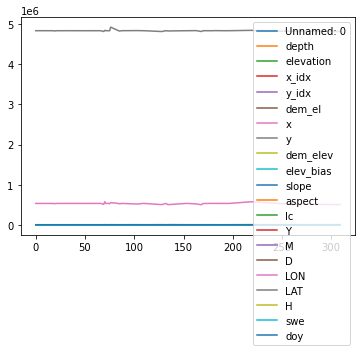

In [6]:
CSO_gdf.plot()

In [51]:
#select data based on desired attribute

CSO_gdf_new = CSO_gdf2[CSO_gdf2.id.isin( CSO_gdf.id.values).values]

In [52]:
CSO_gdf

,Unnamed: 0,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,...,lc,dt,Y,M,D,LON,LAT,H,swe,doy
0,135,POINT (-110.597818510855 43.6701724330154),D3gyiOmE,Katie O’Connell,10.00,MountainHub,2019-04-25T02:25:30.037Z,2131.137695,452,1023,...,6.0,2019-04-25,2019,4,25,-110.597819,43.670172,100.0,0.033626,207
1,136,POINT (-110.598540829639 43.6706713863815),SEJG7WBM,Katie O’Connell,72.00,MountainHub,2019-04-25T02:24:32.498Z,2127.995361,451,1023,...,6.0,2019-04-25,2019,4,25,-110.598541,43.670671,720.0,0.245734,207
2,137,POINT (-110.593582727118 43.6701536877488),Vn9QgQA7,Leanne,27.94,MountainHub,2019-04-24T15:56:24.335Z,2146.224609,455,1023,...,2.0,2019-04-24,2019,4,24,-110.593583,43.670154,279.4,0.094851,206
3,138,POINT (-110.591223958083 43.670516817875),xlFXLIST,Leanne,25.40,MountainHub,2019-04-24T15:53:28.932Z,2156.758057,457,1023,...,1.0,2019-04-24,2019,4,24,-110.591224,43.670517,254.0,0.086550,206
4,139,POINT (-110.598580352962 43.667640969849),4EMEMrPA,Colton Lewer,60.00,MountainHub,2019-04-24T15:53:19.864Z,2188.988770,451,1026,...,1.0,2019-04-24,2019,4,24,-110.598580,43.667641,600.0,0.203867,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,416,POINT (-110.870306 43.590676),8qzaI9zc,Cody McInnes,140.00,SnowPilot,2018-12-05T19:40:00.000Z,2918.032715,232,1112,...,6.0,2018-12-05,2018,12,5,-110.870306,43.590676,1400.0,0.344194,66
303,438,POINT (-110.010724 43.733182),53nEfN14,Chris McCollister,46.00,SnowPilot,2018-11-14T23:00:00.000Z,2847.268799,924,949,...,1.0,2018-11-14,2018,11,14,-110.010724,43.733182,460.0,0.096710,45
306,441,POINT (-110.95167 43.478566),6+xKcZFv,Chris McCollister,68.00,SnowPilot,2018-11-09T00:20:00.000Z,2794.276123,167,1237,...,1.0,2018-11-09,2018,11,9,-110.951670,43.478566,680.0,0.137963,40
307,442,POINT (-110.850197 43.605528),7MKrMQAz,Josh Pope,95.00,SnowPilot,2018-11-08T17:30:00.000Z,2773.990234,248,1096,...,6.0,2018-11-08,2018,11,8,-110.850197,43.605528,950.0,0.193702,39


In [8]:
CSO_gdf=CSO_gdf2.loc[[1,37,90,275,307]]
CSO_gdf.elev_bias

1      -3.995361
37    -17.600098
90    -11.302002
275     2.589355
307    12.009766
Name: elev_bias, dtype: float64

In [7]:
assimPath = '/nfs/attic/dfh/Aragon2/CSOassim/'+domain+'/'
filename = assimPath+'CSO_assim_2018-2019_all_minelevbias10.csv'
#save data for later reference 
CSO_gdf.to_csv(filename)

In [8]:
#1 year simulations 
outFpath = assimPath+'CSO_assim_2018-2019_all_minelevbiasid10.dat'
f= open(outFpath,"w+")

tot_obs=len(CSO_gdf)
uq_day = np.unique(CSO_gdf.dt)
num_days = len(uq_day)
ids = 100
f.write('{:02.0f}\n'.format(num_days))
for j in range(len(uq_day)):
    obs = CSO_gdf[CSO_gdf['dt']==uq_day[j]]
    d=CSO_gdf.D[CSO_gdf['dt']==uq_day[j]].values
    m=CSO_gdf.M[CSO_gdf['dt']==uq_day[j]].values
    y=CSO_gdf.Y[CSO_gdf['dt']==uq_day[j]].values
    date = str(y[0])+' '+str(m[0])+' '+str(d[0])
    obs_count = str(len(obs))
    f.write(date+' \n')
    f.write(obs_count+' \n')
    for k in range(len(obs)):
        ids = ids+1
        x= obs.x[obs.index[k]]
        y=obs.y[obs.index[k]]
        swe=obs.swe[obs.index[k]]
        f.write('{:3.0f}\t'.format(ids)+'{:10.0f}\t'.format(x)+'{:10.0f}\t'.format(y)+'{:3.2f}\n'.format(swe))
f.close() 

In [41]:
#multi year simulations 
outFpath = assimPath+'CSO_assim_2018-2019_all.dat'
f= open(outFpath,"w+")
 
yrs = np.unique(CSO_gdf['Y'])
yr_count = len(yrs)
for i in range(len(yrs)):
    sel = CSO_gdf.dt[CSO_gdf['Y']==yrs[i]]
    uq_day=np.unique(sel)
    sel_count = len(uq_day)
    f.write('{:02.0f}\n'.format(sel_count))
    for j in range(len(uq_day)):
        obs = CSO_gdf[CSO_gdf['dt']==uq_day[j]]
        d=CSO_gdf.D[CSO_gdf['dt']==uq_day[j]].values
        m=CSO_gdf.M[CSO_gdf['dt']==uq_day[j]].values
        y=CSO_gdf.Y[CSO_gdf['dt']==uq_day[j]].values
        date = str(y[0])+' '+str(m[0])+' '+str(d[0])
        obs_count = str(len(obs))
        f.write(date+' \n')
        f.write(obs_count+' \n')
        for k in range(len(obs)):
            ids = 100+k
            x= obs.x[obs.index[k]]
            y=obs.y[obs.index[k]]
            swe=obs.swe[obs.index[k]]
            f.write('{:3.0f}\t'.format(ids)+'{:10.0f}\t'.format(x)+'{:10.0f}\t'.format(y)+'{:3.2f}\n'.format(swe))
f.close() 

In [27]:
swe_dummy = np.random.rand(len(CSO_gdf))
DOY_dummy = np.random.rand(len(CSO_gdf))
CSO_gdf['swe']=swe_dummy
CSO_gdf['doy']=DOY_dummy
CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation,dem_elev,slope,aspect,lc,dt,Y,M,D,LON,LAT,H,swe,doy
0,POINT (-121.88219 44.40203),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647,1736,18.238867,2.0,1.0,2018-01-08,2018,1,8,-121.882193,44.402026,0.4826,0.844727,0.419439
1,POINT (-121.67006 44.06164),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006,2291,24.351591,4.0,18.0,2018-01-29,2018,1,29,-121.670058,44.061643,2.0500,0.679039,0.950846
2,POINT (-121.64243 44.00521),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846,2358,10.525268,0.0,18.0,2018-01-24,2018,1,24,-121.642427,44.005209,2.4000,0.388833,0.894862
3,POINT (-121.68519 44.00710),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476,1910,16.250000,0.0,1.0,2019-12-28,2019,12,28,-121.685192,44.007101,0.6350,0.995717,0.726477
4,POINT (-121.88226 44.40201),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285,1736,18.238867,2.0,1.0,2018-05-01,2018,5,1,-121.882263,44.402010,1.3208,0.698442,0.034035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,POINT (-121.27796 43.71257),ZGXIxK1Z,Bart Wills,81.28,MountainHub,2019-01-25T20:34:05.120Z,1946.420166,1945,4.756575,0.0,1.0,2019-01-25,2019,1,25,-121.277959,43.712569,0.8128,0.174131,0.928904
341,POINT (-121.68917 44.00308),Zkrpj1cA,Aaron Hartz,115.00,MountainHub,2019-01-09T21:40:29.582Z,2015.768555,2040,26.024628,7.0,1.0,2019-01-09,2019,1,9,-121.689170,44.003075,1.1500,0.849100,0.949531
342,POINT (-121.69607 44.02647),ZL/qU18O,Aaron Hartz,120.00,MountainHub,2018-01-19T19:32:57.136Z,1785.061646,2043,31.856121,5.0,1.0,2018-01-19,2018,1,19,-121.696069,44.026466,1.2000,0.953809,0.275016
343,POINT (-121.64619 44.00297),ZLvKCpiv,Bart Wills,86.36,MountainHub,2018-12-01T16:21:02.048Z,2246.336182,2261,21.039398,5.0,6.0,2018-12-01,2018,12,1,-121.646195,44.002967,0.8636,0.635188,0.221266
